# Fitting a 2D Gaussian Tensor Train model to toy data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfm = tf.math

# setup path for repo imports
import sys, os
sys.path.append('../')

## Import Toy data

In [2]:
from data import gen_8gaussians, to_tf_dataset

# Number of datapoints to generate
N = 3000

# Generate toy data
data = gen_8gaussians(batch_size=N)
data = to_tf_dataset(data, batch_size=500)

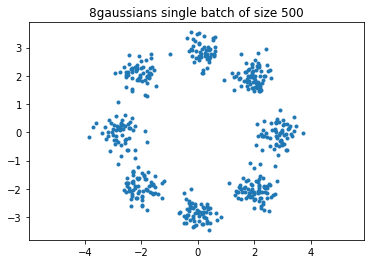

In [3]:
# Plot a single batch of this dataset
single_batch = list(data)[0]
plt.plot(single_batch[:, 0], single_batch[:, 1], '.')
plt.axis('equal')
plt.title(f'8gaussians single batch of size {500}')
plt.show()

## Fit model to data

In [4]:
from models import TensorTrainGaussian2D

In [9]:
# Define number of components
K = 8

# create model
model = TensorTrainGaussian2D(K)

In [10]:
# Define training function
@tf.function
def train_step(data):
    with tf.GradientTape() as tape:
        log_likelihoods = model(data)
        loss = -tf.reduce_mean(log_likelihoods)
    tvars = model.trainable_variables
    gradients = tape.gradient(loss, tvars)
    optimizer.apply_gradients(zip(gradients, tvars))

In [11]:
# Fit the model
EPOCHS = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
losses = []
X = list(data)[0]
for epoch in range(EPOCHS):
    train_step(X)
    
    model.normalize_weights()
    log_likelihoods = model(X)
    loss = (-np.mean(log_likelihoods))
    losses.append(loss)
    if epoch % 100 == 0:
        print("{}/{} mean neg log likelihood: {}".format(epoch, EPOCHS, loss))

0/1000 mean neg log likelihood: 4.29375696182251
100/1000 mean neg log likelihood: 3.9950344562530518
200/1000 mean neg log likelihood: 3.7747607231140137
300/1000 mean neg log likelihood: 3.639965772628784
400/1000 mean neg log likelihood: 3.542583465576172
500/1000 mean neg log likelihood: 3.4699418544769287
600/1000 mean neg log likelihood: 3.3948612213134766
700/1000 mean neg log likelihood: 3.3353915214538574
800/1000 mean neg log likelihood: 3.2817368507385254
900/1000 mean neg log likelihood: 3.245027780532837


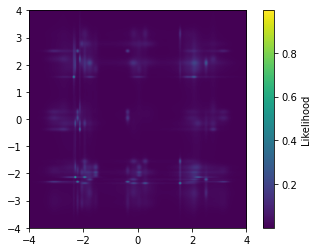

Density integrates to 0.9924
It should be = 1.0


In [12]:
# Set number of points and limits
n_points = 2000
lim = 4

x,dx = np.linspace(-lim, lim, n_points, retstep=True)
y,dy = np.linspace(-lim, lim, n_points, retstep=True)
x_grid, y_grid = np.meshgrid(x, y)
X = np.array([x_grid.ravel(), y_grid.ravel()]).T

p_log = model(X).numpy()
p = np.exp(p_log)

        
# Show density
plt.imshow(
    p.reshape(n_points,n_points),
    extent=(-lim, lim, -lim, lim),
    origin='lower'
)
cbar = plt.colorbar()
cbar.ax.set_ylabel('Likelihood')
plt.plot()
plt.show()


integrand = np.sum(p)*dx*dy
print(f'Density integrates to {round(integrand, 4)}')
print('It should be = 1.0')